# Lesson 2 Random Forests and Feature Analysis

In this lesson we are going to see the following topics:
* RF from scratch
* How RFs perform on real Datasets
* Using sklearn RFs and improving the way they work
* Feature analysis and PDP

But first let me point some important concepts of ML that you must check (remember Google's glossary):
* Ground truth
* Accuracy
* Loss measures
* Confusion matrix
* Underfitting, overfitting, generalization curve
* Cross-validation
* class-imbalanced dataset

https://developers.google.com/machine-learning/glossary/?hl=en-419

## RF from scratch
Quite easy since we previously did the DT from scratch

https://en.wikipedia.org/wiki/Random_forest

The main thing is:
**Random Forests correct for decision trees' habit of overfitting to their training set.**

They avoid overfitting with ensembling technique... **What is ensembling?**

### Bagging examples
As we have already built our own DT, we already understand how DTs work. Thus, we are going to work with sklearn DT but we are going to build our own RF algorithm.

In [1]:
import numpy as np
from numpy.polynomial.polynomial import polyval
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

In [2]:
class RF():
    def __init__(self,n_trees,frac_examples=0.1,kind="clas",tree_params={}):
        
        self.frac_examples = frac_examples
        self.n_trees = n_trees
        self.kind = kind
        self.tree_params = tree_params
        
        if self.kind == "clas":
            self.estimators = [DecisionTreeClassifier() for i in range(self.n_trees)]
        else:
            self.estimators = [DecisionTreeRegressor() for i in range(self.n_trees)]            
    
    def train(self,df,x_labels,y_label):
        self.x_labels = x_labels
        self.y_label = y_label
        for t in self.estimators:
            t_df = df.sample(frac=self.frac_examples)
            t.fit(t_df[self.x_labels],t_df[self.y_label]) ## this is random, we can put rs
    
    def predict(self,df):
        return np.array([t.predict(df[self.x_labels]) for t in self.estimators]).mean(axis=0)
            

In [3]:
my_rf = RF(10,0.2,"reg")

In [4]:
## Generating synth data, as in lesson 2 part 2
x = np.linspace(0,10,100)
y = polyval(x,np.array([1,-2,3,-4,5])/4e4) +  np.random.normal(0,1e-1,x.shape) 

idxs = np.random.randint(0,x.shape[0],40).tolist()
x_train = x[idxs]
y_train = y[idxs]

df_train = pd.DataFrame([x_train,y_train]).T
df_total = pd.DataFrame([x,y]).T

In [5]:
df_train.head()

,0,1
0,2.121212,-0.066451
1,4.848485,0.014044
2,8.787879,0.701111
3,9.595960,0.857425
4,8.686869,0.841570


In [6]:
my_rf.train(df_train,[0],[1])

In [7]:
preds = my_rf.predict(df_total)

In [8]:
import matplotlib.pyplot as plt

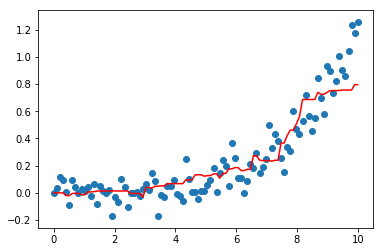

In [9]:
plt.scatter(x,y)
plt.plot(x,preds,c="r");

<span style="color:blue">**In-class**: Implement MSE and MAE as a function, and try to fit a simple RF. </span>

### Bagging features

In [10]:
class RF_v2():
    def __init__(self,n_trees,frac_examples=0.1,
                 frac_features=0.2,kind="clas",max_depth=None):
        
        self.frac_examples = frac_examples
        self.frac_features = frac_features
        self.n_trees = n_trees
        self.kind = kind
        self.max_depth = max_depth
        
        if self.kind == "clas":
            self.estimators = [DecisionTreeClassifier(max_depth=self.max_depth) 
                               for i in range(self.n_trees)]
        else:
            self.estimators = [DecisionTreeRegressor(max_depth=self.max_depth) 
                               for i in range(self.n_trees)]            
    
    def train(self,df,x_labels,y_label):
        self.r_cols = []
        
        self.x_labels = x_labels
        self.y_label = y_label
        for t in self.estimators:
            r_cols = np.random.choice(x_labels, int(self.frac_features*len(x_labels)), 
                                  replace=False).tolist()

            self.r_cols.append(r_cols)
            t_df = df.sample(frac=self.frac_examples).reset_index(drop=True)
            t.fit(X=t_df[r_cols],y=t_df[self.y_label])
    
    def predict(self,df):
        return np.array([t.predict(df[self.r_cols[i]]) 
                         for i,t in enumerate(self.estimators)]).mean(axis=0)            

But we do not have enough features on our synth dataset to test our new RF algorithm. We need a dataset with more features.

## Unsynthetic Dataset

http://mlr.cs.umass.edu/ml/datasets/Adult

http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/

About predicting if one adult will earn more or less than $50k
### Download and preliminary DA

In [11]:
# !ls; mkdir data;

In [12]:
# ! cd data; ls

In [13]:
# ! cd data; wget http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/adult.data

In [14]:
# ! cd data; wget http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/adult.test

In [15]:
cols = ["age",
"workclass",
"fnlwgt",
"education",
"education-num",
"marital-status",
"occupation",
"relationship",
"race",
"sex",
"capital-gain",
"capital-loss",
"hours-per-week",
"native-country",
"label"]

In [16]:
train_df = pd.read_csv("data/adult.data",header=None,names=cols)
test_df = pd.read_csv("data/adult.test",header=None,names=cols)

In [17]:
y_label = "label"
x_labels = cols[:-1]

In [18]:
train_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [19]:
test_df["label"] = test_df["label"].apply(lambda x: x.replace(".","")) 
test_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


We can see `?` as values, so at the end there will be no NaN values. This is good? bad? How we can deal with that?

**Initial Data Analysis**

First we need to convert string data into categories. The following functions were extracted from a previous version of fastai course.

In [20]:
from pandas.api.types import is_string_dtype, is_numeric_dtype

def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()
                                                                ## order is important

def apply_cats(df, trn):
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = c.astype('category').cat.as_ordered()
                                            ## to have same order as train
            df[n].cat.set_categories(trn[n].cat.categories, ordered=True, inplace=True)

In [21]:
train_cats(train_df)

We would like to apply the same categories to the test set.

In [22]:
apply_cats(test_df,train_df)

In [23]:
train_df.dtypes

age                  int64
workclass         category
fnlwgt               int64
education         category
education-num        int64
marital-status    category
occupation        category
relationship      category
race              category
sex               category
capital-gain         int64
capital-loss         int64
hours-per-week       int64
native-country    category
label             category
dtype: object

In [24]:
from pandas_summary import DataFrameSummary

In [25]:
ds = DataFrameSummary(train_df)

In [26]:
ds.columns_stats

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
counts,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561
uniques,73,9,21648,16,16,7,15,6,5,2,119,92,94,42,2
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
missing_perc,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
types,numeric,categorical,numeric,categorical,numeric,categorical,categorical,categorical,categorical,bool,numeric,numeric,numeric,categorical,bool


mean                         38.5816
std                          13.6404
variance                     186.061
min                               17
max                               90
5%                                19
25%                               28
50%                               37
75%                               48
95%                               63
iqr                               20
kurtosis                   -0.166127
skewness                    0.558743
sum                          1256257
mad                          11.1892
cv                          0.353547
zeros_num                          0
zeros_perc                        0%
deviating_of_mean                121
deviating_of_mean_perc         0.37%
deviating_of_median              540
deviating_of_median_perc       1.66%
top_correlations                    
counts                         32561
uniques                           73
missing                            0
missing_perc                      0%
t

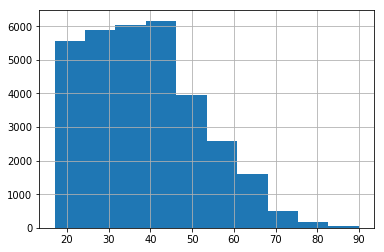

In [27]:
ds["age"]

In [28]:
ds["label"]

" <=50K" count     24720
" <=50K" perc     75.92%
" >50K" count       7841
" >50K" perc      24.08%
counts             32561
uniques                2
missing                0
missing_perc          0%
types               bool
Name: label, dtype: object

In [29]:
import seaborn as sns

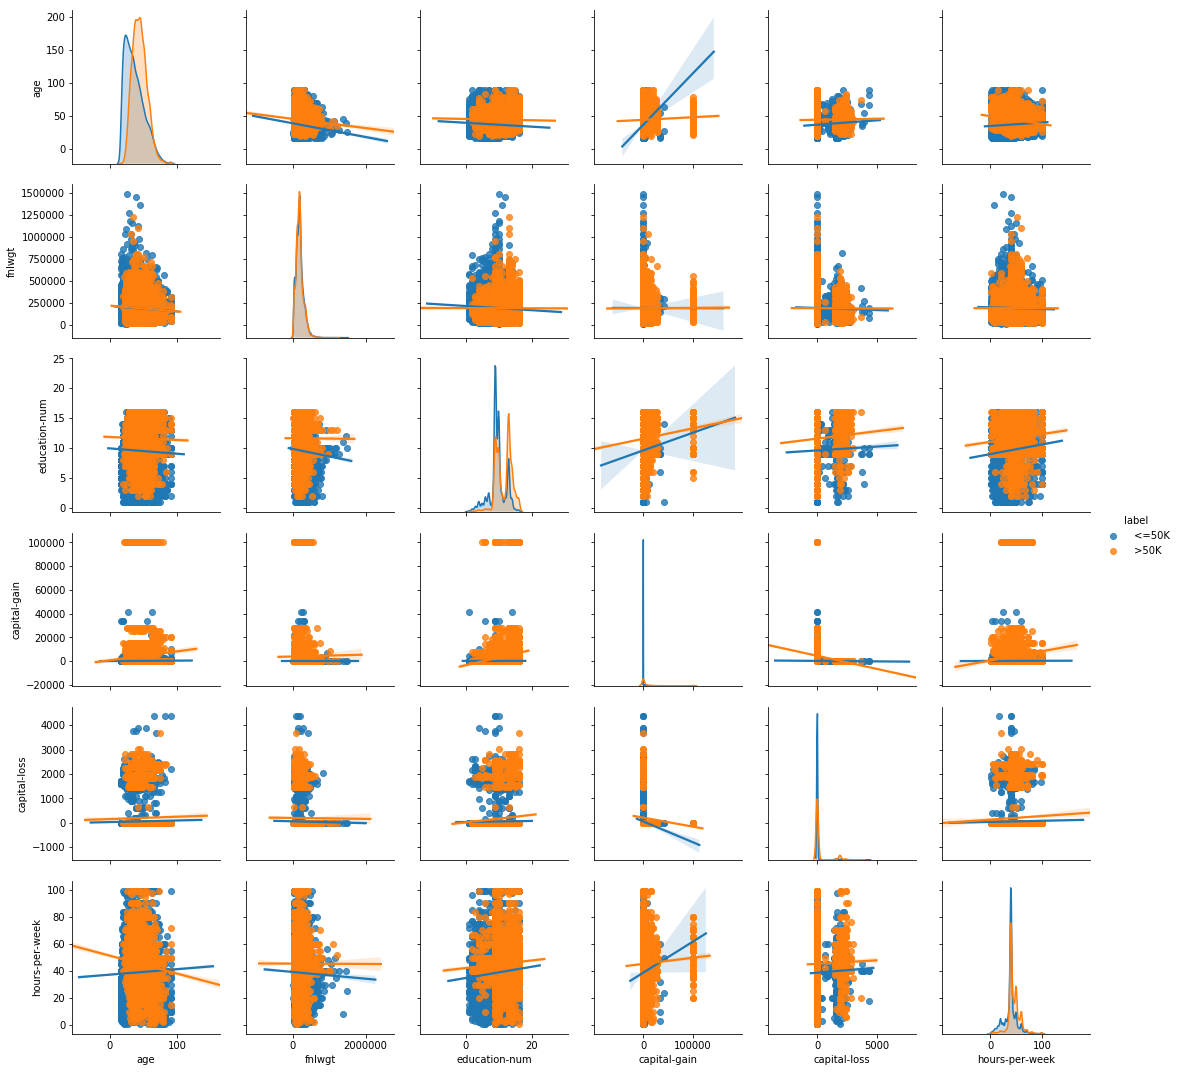

In [30]:
sns.pairplot(train_df,kind="reg",hue="label") ## too slow and just numerical features

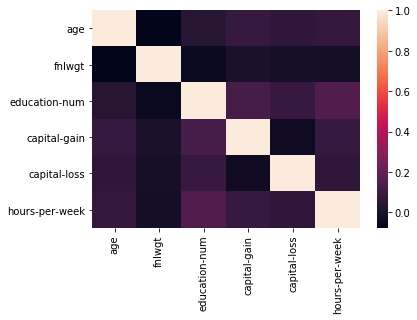

In [31]:
sns.heatmap(train_df.corr()) # just numerical vars

It seems that we must analyze numerical features, we will need to craft some functions to convert all the data to numeric. The following functions were extracted from a previous version of fastai course.

In [32]:
def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = col.cat.codes+1

In [33]:
def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

In [34]:
def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = df[y_fld].cat.codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

In [35]:
train_df_2, y_lbl_train, na_dict = proc_df(train_df,"label")
test_df_2,y_lbl_test,na_dict = proc_df(test_df,"label",na_dict=na_dict)

A very cool way to save data, is in binary format, is FAST so you can work with huge files. 

In [36]:
# ! pip install feather-format

In [37]:
pd.concat([train_df_2,pd.DataFrame(y_lbl_train,columns=["label"])],axis=1).to_feather("data/adult_train.f")
pd.concat([test_df_2,pd.DataFrame(y_lbl_test,columns=["label"])],axis=1).to_feather("data/adult_test.f")

Now we can re-do the plots to see if we can extract some useful information.

In [38]:
# sns.pairplot(pd.concat([train_df_2,pd.DataFrame(y_lbl_train,columns=["label"])],axis=1),
#              kind="reg",hue="label",diag_kind="hist") ## much slower and not that useful

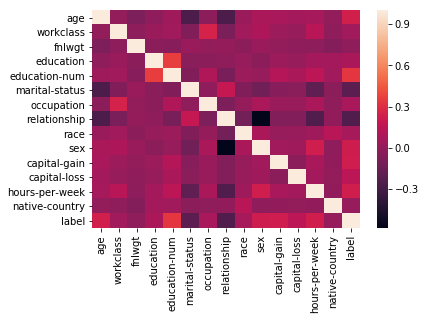

In [39]:
sns.heatmap(pd.concat([train_df_2,pd.DataFrame(y_lbl_train,columns=["label"])],axis=1).corr());

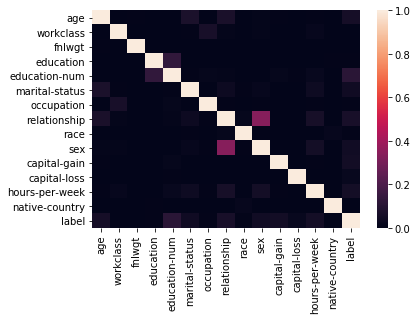

In [40]:
sns.heatmap(pd.concat([train_df_2,pd.DataFrame(y_lbl_train,columns=["label"])],axis=1).corr()**2);

label is quite correlated to `age`, `education-num`, `hours-per-week`, `sex`, `capital-gain`

In [41]:
my_rf_2 = RF_v2(
                n_trees=50,
                frac_examples=0.5,
                frac_features=0.4,
                kind="clas",
                max_depth=14
                )

The above params try to make trees as uncorrelated as possible.

In [42]:
my_rf_2.train(pd.concat([train_df_2,pd.DataFrame(y_lbl_train,columns=["label"])],axis=1)
              ,x_labels,y_label)

Plot results and predict on `adults.test`

In [43]:
f"train acc: {np.sum(np.round(my_rf_2.predict(train_df_2)) == y_lbl_train)/len(y_lbl_train)}"

'train acc: 0.8643776296796781'

In [44]:
f"test acc: {np.sum(np.round(my_rf_2.predict(test_df_2)) == y_lbl_test)/len(y_lbl_test)}"

'test acc: 0.8469381487623611'

## Sklearn RF and more options

In [45]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
clf = RandomForestClassifier(n_estimators=10)
X = pd.concat([train_df_2,pd.DataFrame(y_lbl_train,columns=["label"])],axis=1)[x_labels]
y = pd.concat([train_df_2,pd.DataFrame(y_lbl_train,columns=["label"])],axis=1)[y_label]
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [47]:
f"train acc: {np.sum(clf.predict(train_df_2) == y_lbl_train)/len(y_lbl_train)}"

'train acc: 0.9878074997696631'

In [48]:
f"test acc: {np.sum(clf.predict(test_df_2) == y_lbl_test)/len(y_lbl_test)}"

'test acc: 0.8495178428843437'

Now we can finetune this classifier

In [49]:
clf = RandomForestClassifier(n_estimators=100,oob_score=True,
                             max_depth=20,max_features="sqrt")
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

What is oob_score? Is a good way to validate the model?

In [50]:
clf.oob_score_,f"test acc: {np.sum(clf.predict(test_df_2) == y_lbl_test)/len(y_lbl_test)}"

(0.8638248211050029, 'test acc: 0.8629691050918248')

In [51]:
clf.feature_importances_

array([0.12372515, 0.03502447, 0.10564298, 0.03757304, 0.11486704,
       0.07217977, 0.05848812, 0.14260362, 0.01313862, 0.01512604,
       0.14387398, 0.04404585, 0.07697411, 0.01673722])

In [52]:
imps = {}
for i in range(len(X.columns.values)):
    imps[X.columns.values[i]] = clf.feature_importances_[i]
imps

{'age': 0.12372514707831718,
 'workclass': 0.035024472831443235,
 'fnlwgt': 0.10564297684370233,
 'education': 0.037573043631886904,
 'education-num': 0.1148670438393403,
 'marital-status': 0.07217976849577008,
 'occupation': 0.05848812265496108,
 'relationship': 0.14260361895291002,
 'race': 0.013138619623118145,
 'sex': 0.015126037348736764,
 'capital-gain': 0.14387397601616495,
 'capital-loss': 0.044045846917613145,
 'hours-per-week': 0.07697410553795397,
 'native-country': 0.016737220228081974}

In [53]:
imps = dict(sorted(imps.items(), key=lambda kv: kv[1],reverse=True))

In [54]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

## Feature analysis and PDP

What you can change if you want to earn more than 50k?  during 1996

In [55]:
data = [go.Bar(
            x=list(imps.keys()),
            y=list(imps.values())
    )]

iplot(data, filename='basic-bar')

If we look at wierd variables, we can see that:

* capital gains= income from investment sources, apart from wages/salary
* capital loss= losses from investment sources, apart from wages/salary
* fnlwgt= sampling weight, more here: SIPP Weighting (wierd index)

As expected from the definition, if someone has some capital invested somewhere, probably is making good money and therefore they can invest.

In [56]:
train3 = pd.concat([train_df_2,pd.DataFrame(y_lbl_train,columns=["label"])],axis=1)

train3["less_20"] = train3["age"].apply(lambda x: 1 if x < 20 else 0)
train3["20_to_50"] = train3["age"].apply(lambda x: 1 if 20 <= x <= 50 else 0)
train3["over_50"] = train3["age"].apply(lambda x: 1 if x > 50 else 0)

del train3["fnlwgt"]

In [57]:
clf = RandomForestClassifier(n_estimators=100,oob_score=True,
                             max_depth=15,max_features="sqrt")
X = train3[train3.columns.values[:13].tolist()+train3.columns.values[14:].tolist()]
y = train3[train3.columns.values[13]]
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [58]:
f"train acc: {np.sum(clf.predict(X) == y)/len(y)}",f"oob: {clf.oob_score_}"

('train acc: 0.9021835938699672', 'oob: 0.864500476029606')

In [59]:
def plot_imps(clf,X):
    imps = {}
    for i in range(len(X.columns.values)):
        imps[X.columns.values[i]] = clf.feature_importances_[i]
    imps = dict(sorted(imps.items(), key=lambda kv: kv[1],reverse=True))
    data = [go.Bar(
            x=list(imps.keys()),
            y=list(imps.values())
    )]

    iplot(data)
    return imps

In [60]:
imps = plot_imps(clf,X)

New variables seem to be useless by now, but removing `fnlwgt` seems good decision.

In [61]:
# ! pip install pdpbox

In [62]:
from pdpbox import pdp, get_dataset, info_plots

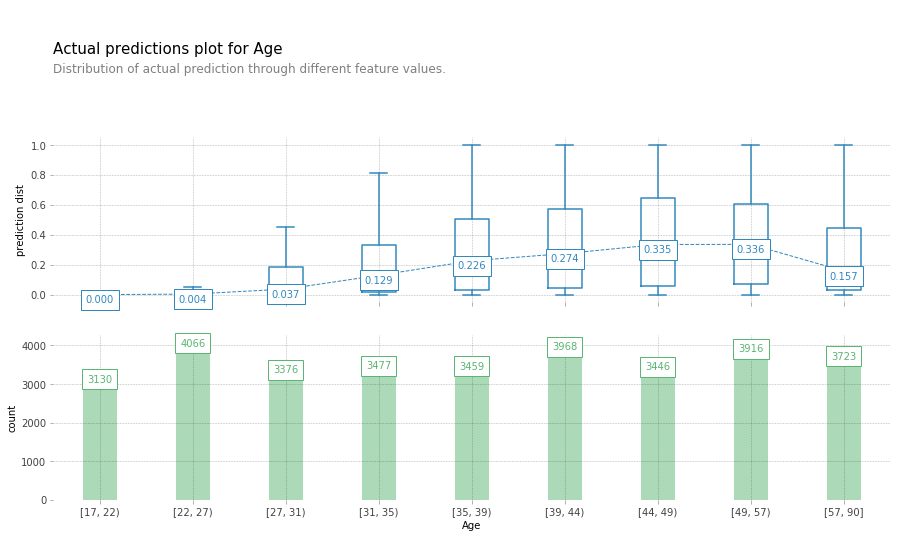

In [63]:
fig, axes, summary_df = info_plots.actual_plot(
    model=clf, X=X, feature='age', feature_name='Age',
    predict_kwds={}
)

In [64]:
pdp_age = pdp.pdp_isolate(
    model=clf, dataset=X, model_features=X.columns.values.tolist(), 
    feature="age"
)

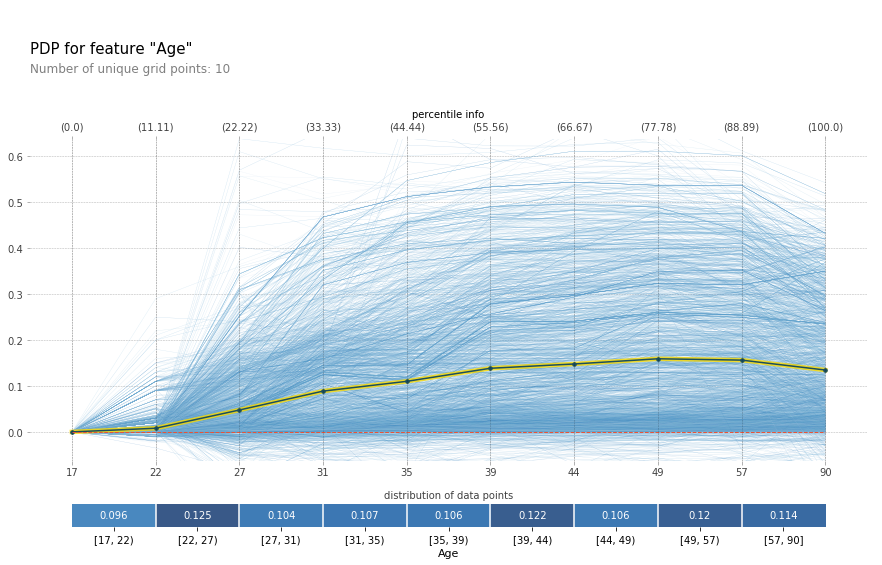

In [65]:
fig, axes = pdp.pdp_plot(pdp_age, "Age", frac_to_plot=0.1, 
                         plot_lines=True, x_quantile=True, 
                         show_percentile=True, plot_pts_dist=True
                        ) ## slow again

So from 22 to 27 we should ask for higher salaries.

We can also plot interactions between variables:

In [66]:
inter1 = pdp.pdp_interact(
    model=clf, dataset=X, model_features=X.columns.values.tolist(),
    features=["age", "marital-status"]
)

In [67]:
# fig, axes = pdp.pdp_interact_plot(
#     pdp_interact_out=inter1, feature_names=["age", "marital-status"], 
#     plot_type='contour', x_quantile=False, plot_pdp=False)

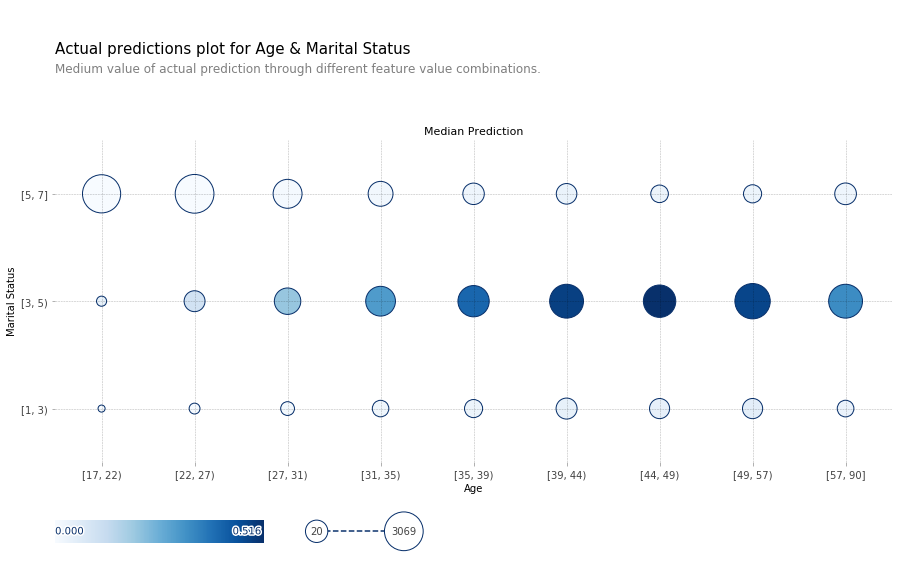

In [68]:
fig, axes, summary_df = info_plots.actual_plot_interact(
    model=clf, X=X, 
    features=["age", "marital-status"], feature_names=['Age', 'Marital Status']
)

In [69]:
pdp_h = pdp.pdp_isolate(
    model=clf, dataset=X, model_features=X.columns.values.tolist(), 
    feature="hours-per-week"
)

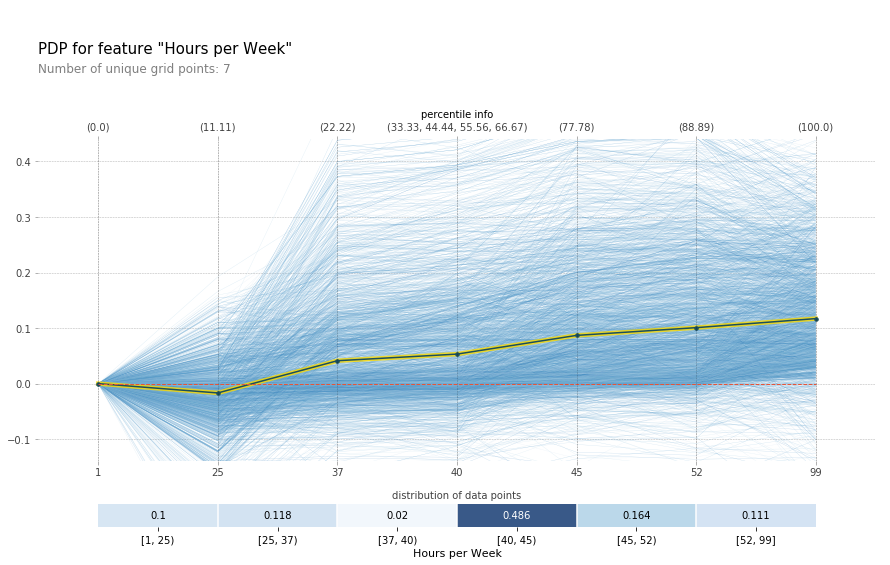

In [70]:
fig, axes = pdp.pdp_plot(pdp_h, "Hours per Week", frac_to_plot=0.1, 
                         plot_lines=True, x_quantile=True, 
                         show_percentile=True, plot_pts_dist=True
                        )

This above plot does not have sense as the salary decreases as the hours increase from 1 to 25 which is wierd. This can be probably explained by other variables that are also correlated with `hours-per-week`.

Looking at the algorithms officialy tested on this dataset, we can find the following information.  
  
  Rank | Algorithm            |       Error
 ------|----------------------|---------------
 1     |  C4.5                |       15.54
 2     |   C4.5-auto          |       14.46
 3     |   C4.5 rules         |       14.94
 4     |Voted ID3 (0.6)       |       15.64
 5     |Voted ID3 (0.8)       |       16.47
 6     |T2                    |       16.84
 7     |1R                    |       19.54
 8     |  NBTree              |       14.10
 9     |  CN2                 |       16.00
 10    | HOODG                |       14.82
 11    | FSS Naive Bayes      |       14.05
 12    | IDTM (Decision table)|       14.46
 13    | Naive-Bayes          |       16.12
 14    | Nearest-neighbor (1) |       21.42
 15    | Nearest-neighbor (3) |       20.35
 16    | OC1                  |       15.04
 17    | Pebls                |       Crashed

In [71]:
test3 = test_df_2

In [72]:
test3["less_20"] = test3["age"].apply(lambda x: 1 if x < 20 else 0)
test3["20_to_50"] = test3["age"].apply(lambda x: 1 if 20 <= x <= 50 else 0)
test3["over_50"] = test3["age"].apply(lambda x: 1 if x > 50 else 0)

del test3["fnlwgt"]

In [73]:
f"test error: {1 - np.sum(clf.predict(test3) == y_lbl_test)/len(y_lbl_test)}"

'test error: 0.1366623671764634'

<span style="color:blue">**In-class**: Try the above RF tricks with your own dataset example </span>